# Linear Regression

This notebook implements **Linear Regression using Gradient Descent**, without using `sklearn`'s regression models.

We apply it to the **Spotify Top Songs dataset**, predicting **popularity** using acoustic features.

The workflow mirrors professional ML pipelines:

1. **Data Inspection**
2. **Visualization**
3. **Preprocessing & Scaling**
4. **Manual Linear Regression (Gradient Descent)**
5. **Evaluation (MSE, MAE, R²)**
6. **Interpretation of learned weights**

This notebook pairs with the custom model in: spotiml/linear_regression.py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from spotiml.linear_regression import LinearRegressionGD

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("topsongs.csv")
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


## 🔍 Data Inspection

We begin with an overview of dataset shape, columns, and statistical summary.

In [7]:
print("Dataset shape:", df.shape)
df.describe(include="all")

Dataset shape: (2000, 18)


,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
count,2000,2000,2000.000000,2000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000
unique,835,1879,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59
top,Rihanna,Sorry,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pop
freq,25,5,NaN,1449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,428
mean,NaN,NaN,228748.124500,NaN,2009.49400,59.872500,0.667438,0.720366,5.378000,-5.512434,0.553500,0.103568,0.128955,0.015226,0.181216,0.551690,120.122558,NaN
std,NaN,NaN,39136.569008,NaN,5.85996,21.335577,0.140416,0.152745,3.615059,1.933482,0.497254,0.096159,0.173346,0.087771,0.140669,0.220864,26.967112,NaN
min,NaN,NaN,113000.000000,NaN,1998.00000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000,NaN
25%,NaN,NaN,203580.000000,NaN,2004.00000,56.000000,0.581000,0.622000,2.000000,-6.490250,0.000000,0.039600,0.014000,0.000000,0.088100,0.386750,98.985750,NaN
50%,NaN,NaN,223279.500000,NaN,2010.00000,65.500000,0.676000,0.736000,6.000000,-5.285000,1.000000,0.059850,0.055700,0.000000,0.124000,0.557500,120.021500,NaN
75%,NaN,NaN,248133.000000,NaN,2015.00000,73.000000,0.764000,0.839000,8.000000,-4.167750,1.000000,0.129000,0.176250,0.000068,0.241000,0.730000,134.265500,NaN


## 🎼 Feature Selection

We use the following acoustic features as predictors:

- danceability  
- energy  
- loudness  
- speechiness  
- acousticness  
- instrumentalness  
- liveness  
- valence  
- tempo  

**Target variable:** `popularity` (continuous)

This is a classic regression task.

In [10]:
features = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]

X = df[features].values
y = df["popularity"].values

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (2000, 9)
Target shape: (2000,)


## 📊 Feature Visualization

Pairplots and correlation heatmaps help us understand:

- Which features correlate with popularity  
- Whether linear relationships are plausible  
- Potential multicollinearity  

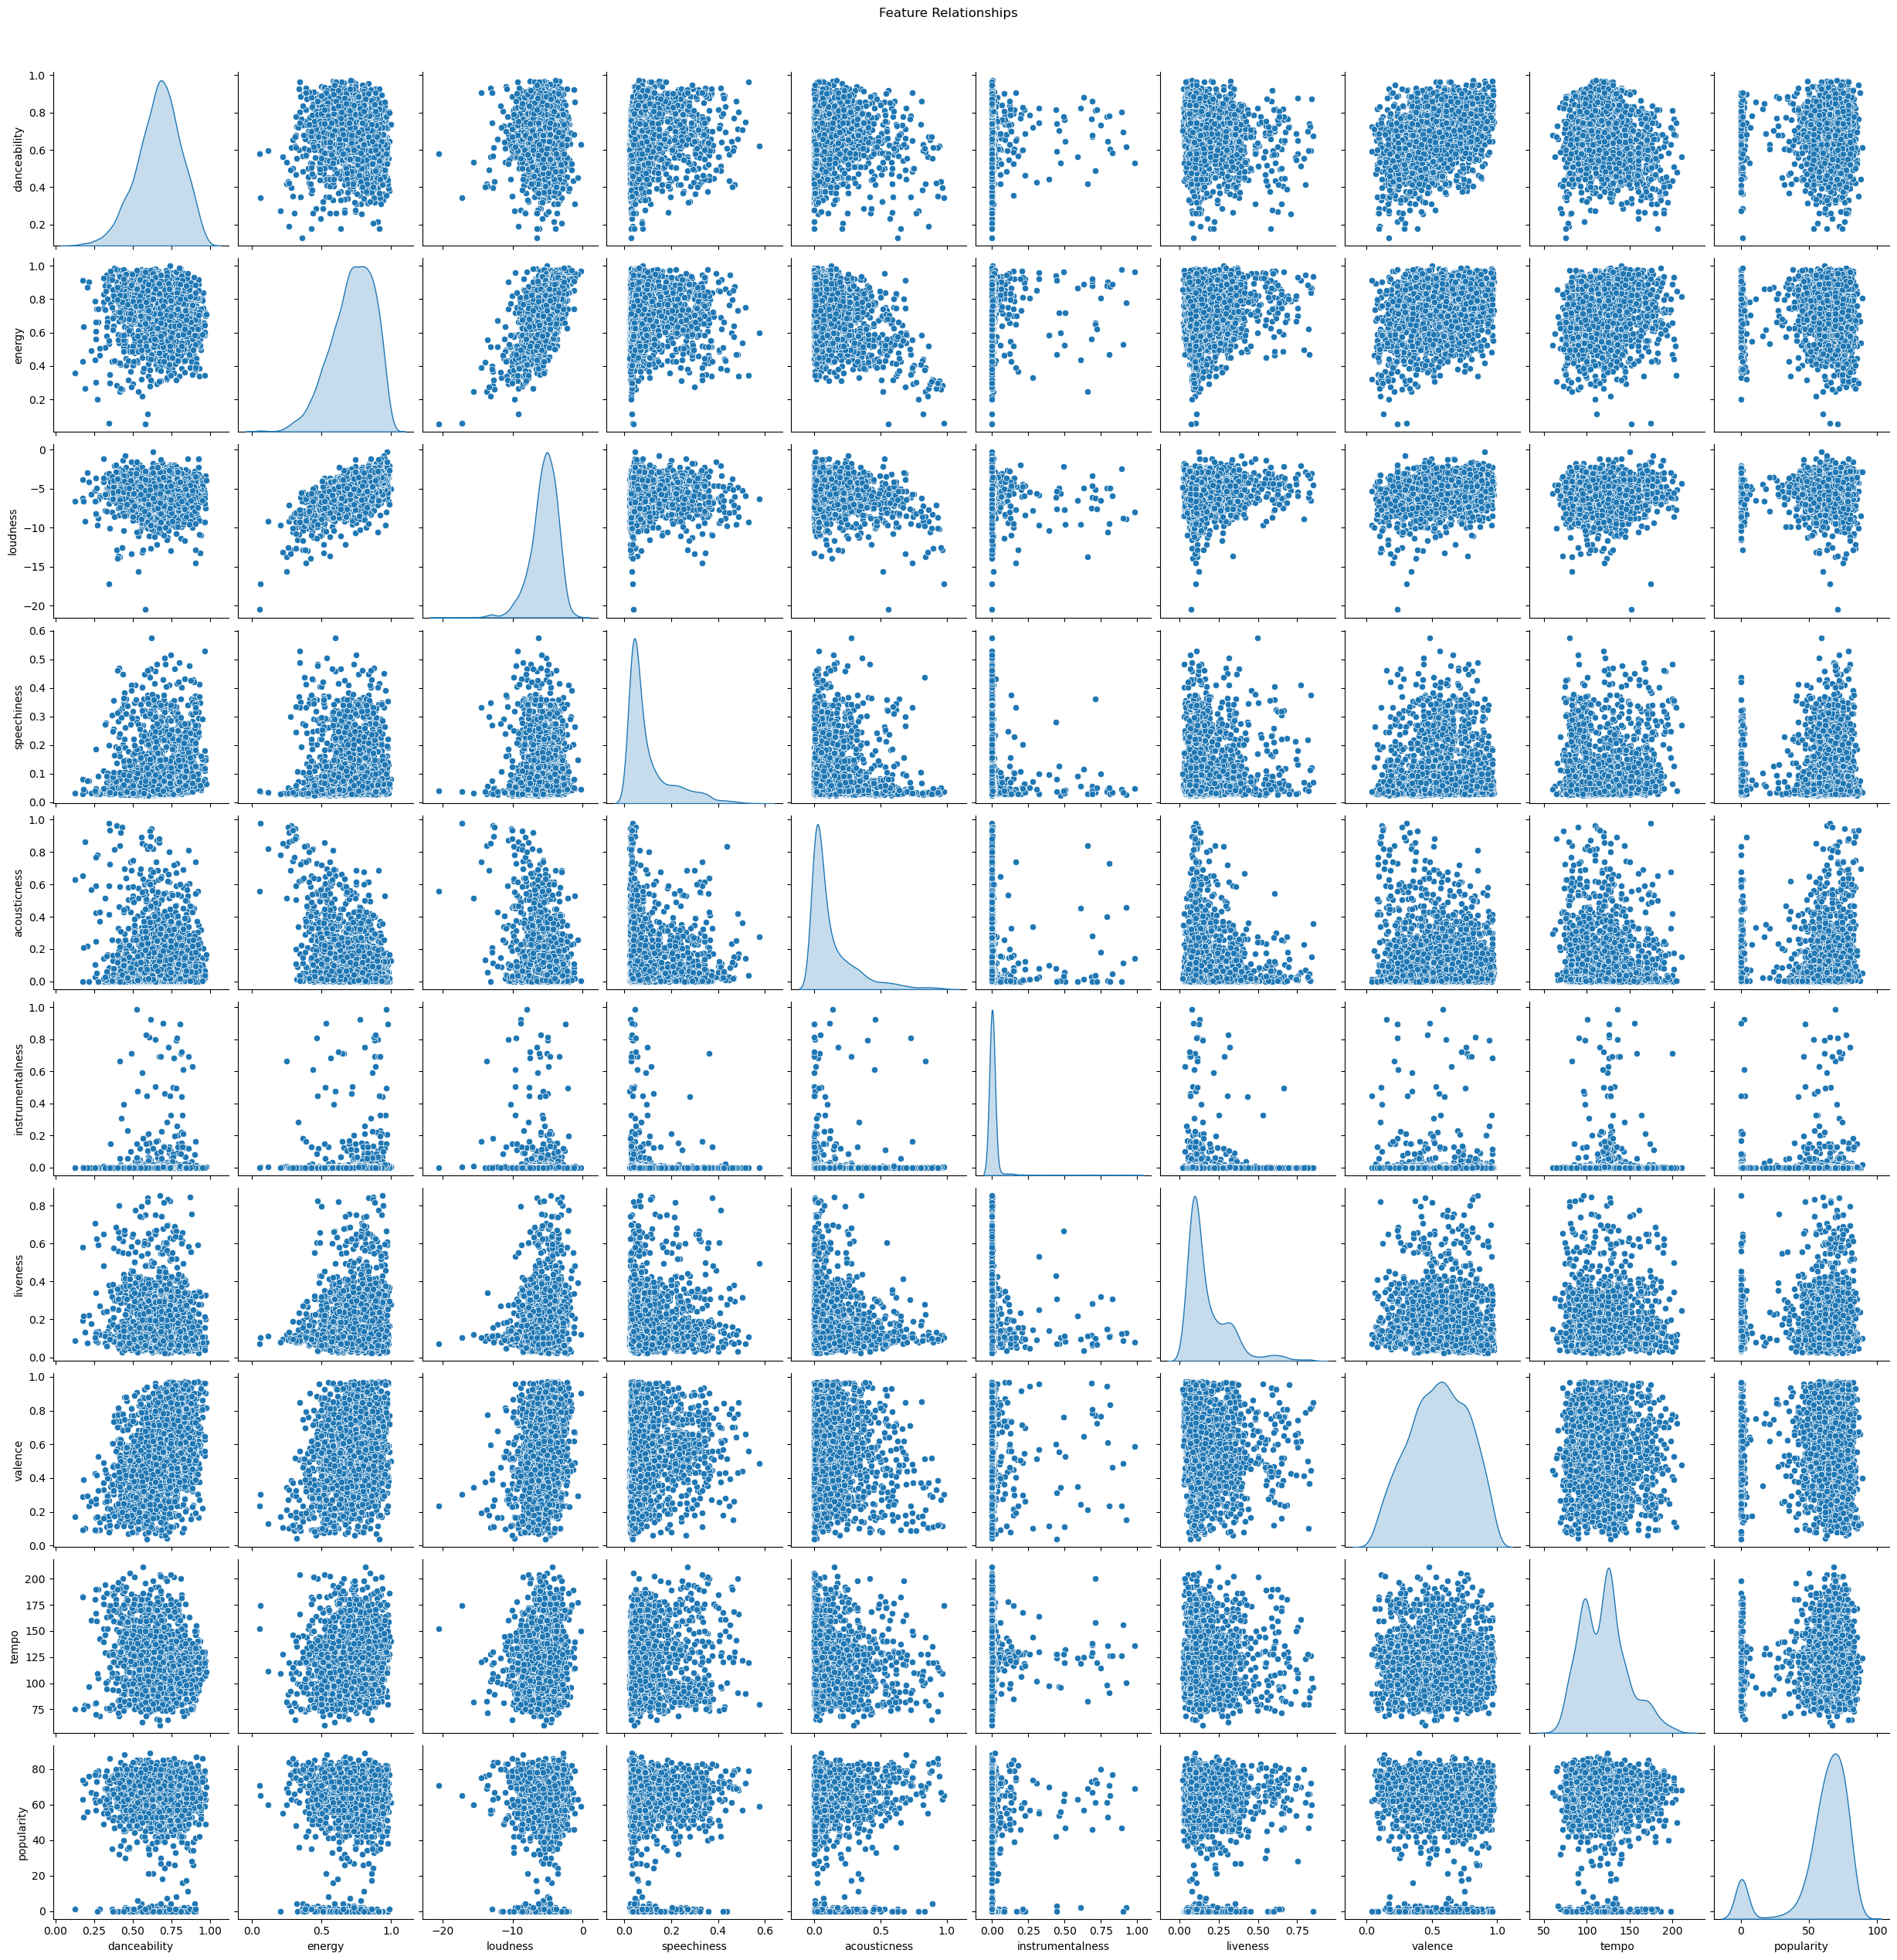

In [13]:
sns.pairplot(df[features + ["popularity"]], diag_kind="kde")
plt.suptitle("Feature Relationships", y=1.02)
plt.show()

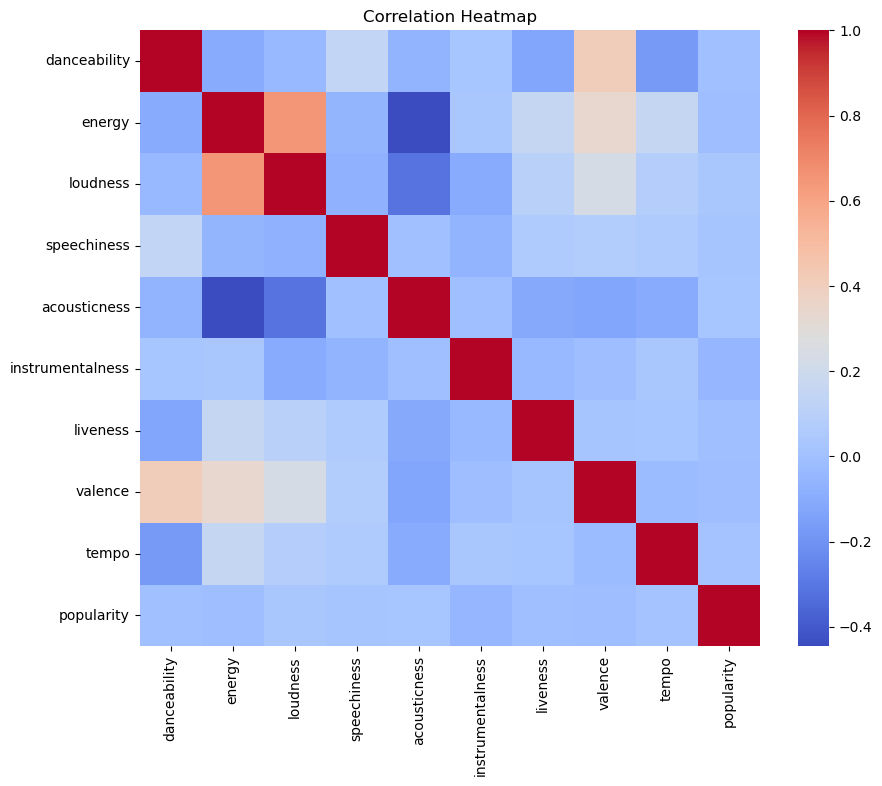

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df[features + ["popularity"]].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## ✂️ Train/Test Split

We use an 80/20 split to evaluate model generalization on unseen data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((1600, 9), (400, 9))

## ⚖️ Feature Scaling

Linear Regression with Gradient Descent requires scaling for:

- stable convergence  
- well-behaved loss surface  
- equal weighting across features  

We standardize each feature to:

\[
z = \frac{x - \mu}{\sigma}
\]

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 🧠 Training Linear Regression (Gradient Descent)

We fit our manual implementation:

- Learning rate: `0.01`  
- Iterations: `3000`  
- Loss function: Mean Squared Error  

The model stores loss history so we can visualize convergence.

In [24]:
model = LinearRegressionGD(
    lr=0.01,
    n_iters=3000,
    verbose=False
)

model.fit(X_train_scaled, y_train)

## 📉 Training Loss Curve

A smooth downward curve indicates successful gradient descent optimization.

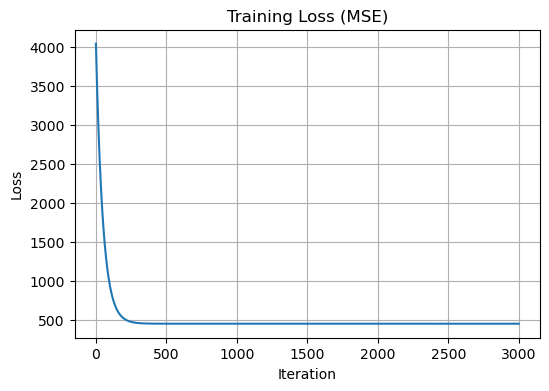

In [27]:
plt.figure(figsize=(6,4))
plt.plot(model.loss_history)
plt.title("Training Loss (MSE)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## 🎯 Predictions

We now evaluate the model on the test set and inspect the first few outputs.

In [30]:
y_pred = model.predict(X_test_scaled)

pd.DataFrame({
    "Actual": y_test[:10],
    "Predicted": y_pred[:10]
})

,Actual,Predicted
0,72,61.591739
1,72,60.837684
2,60,58.773068
3,74,60.925610
4,74,61.648231
5,82,61.285468
6,3,59.616694
7,76,59.228947
8,58,59.159892
9,68,60.483575


## 📊 Evaluation Metrics

We compute:

### **Mean Squared Error**
\[
MSE = \frac{1}{n}\sum (y - \hat{y})^2
\]

### **Mean Absolute Error**
\[
MAE = \frac{1}{n}\sum |y - \hat{y}|
\]

### **R² Score**
\[
R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}
\]

These measure accuracy, error magnitude, and explanatory power.

In [33]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

print(f"MSE: {mse(y_test, y_pred):.3f}")
print(f"MAE: {mae(y_test, y_pred):.3f}")
print(f"R² Score: {r2(y_test, y_pred):.3f}")

MSE: 475.047
MAE: 14.964
R² Score: 0.008


## 📈 Predicted vs Actual Popularity

A tighter diagonal cluster indicates better predictions.

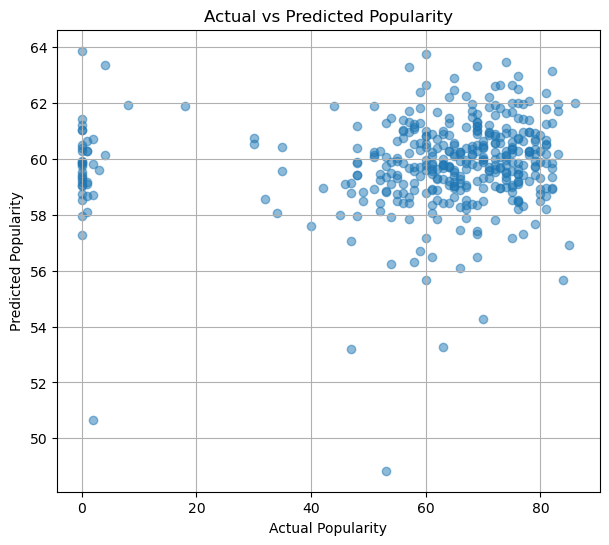

In [36]:
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Actual vs Predicted Popularity")
plt.grid(True)
plt.show()

## 🧩 Interpreting Learned Weights

The learned coefficients reveal which audio features most strongly influence the model's prediction of song popularity. Although the model’s overall R² score is very low (0.008), meaning it captures almost none of the true variance in popularity, the weights still provide insight into how linear regression *attempts* to map audio features to outcomes.

### **Key Observations from Coefficients**

- **Loudness (+1.2772)**  
  The strongest positive coefficient. Louder tracks are *slightly* more likely to be predicted as popular. This aligns with the dataset’s strongest observable correlation: **energy and loudness**, the only semi-strong pairwise relationship.

- **Energy (−1.1313)**  
  Despite being strongly correlated with loudness in the dataset, energy has a *negative* learned weight. This indicates the model struggled to disentangle overlapping features due to multicollinearity.

- **Acousticness (+0.4588)** and **Tempo (+0.4346)**  
  Mild positive contributions, though not strong enough to meaningfully affect predictions.

- **Instrumentalness (−0.7023)**  
  Suggests instrumental tracks are predicted as *less* popular—a reasonable trend given that charting hits typically include vocals.

- **Other Features (small magnitudes)**  
  Danceability, speechiness, liveness, and valence all have weak effects, suggesting no clear linear relationship with popularity in this dataset.

### **Interpretation Summary**
These coefficients reflect **weak, unstable relationships**, consistent with:

- The noisy nature of the target variable (`popularity`)
- The lack of linear structure in the audio features
- Significant multicollinearity (especially between energy and loudness)
- A low R² value indicating extremely limited predictive power

Thus, while the weight directions are interpretable, **the model is not reliable for explanation or prediction**.

Learned Weights:
danceability   : 0.1313
energy         : -1.1313
loudness       : 1.2772
speechiness    : 0.1374
acousticness   : 0.4588
instrumentalness: -0.7023
liveness       : -0.1667
valence        : -0.0889
tempo          : 0.4346


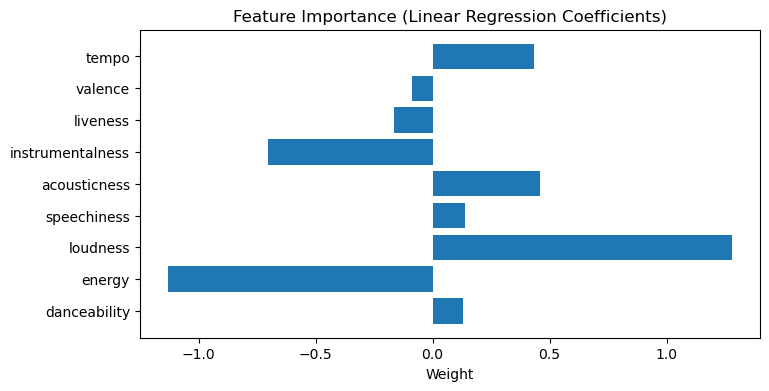

In [43]:
print("Learned Weights:")
for f, w in zip(features, model.weights):
    print(f"{f:15s}: {w:.4f}")

plt.figure(figsize=(8,4))
plt.barh(features, model.weights)
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Weight")
plt.show()


# 📌 Summary & Interpretation

### **Overall Performance**
The linear regression model performed *very poorly* on this dataset:

- **MSE:** 475.047  
- **MAE:** 14.964  
- **R² Score:** **0.008**

The R² score indicates that the model explains **less than 1% of the variance** in song popularity. In practical terms, this means:

➡️ **Linear Regression is essentially no better than predicting the mean popularity for every song.**

### **Why Did Performance Fail?**

Several structural issues in the dataset explain the weak results:

1. **Popularity is not strongly tied to audio features.**  
   Social factors (marketing, virality, artist fame, playlist placement) drive popularity far more than acoustics.

2. **The feature relationships are weak.**  
   The only semi-strong correlation in the entire dataset is between **energy and loudness**, two features that also produce multicollinearity problems for linear models.

3. **Target variable is noisy and non-linear.**  
   Popularity on streaming platforms follows power-law dynamics, algorithmic boosting, release timing, and cultural trends—not linear acoustic patterns.

4. **Model bias toward the mean.**  
   Predictions clustered tightly around ~60, failing to capture high-popularity tracks (70–89) or low-popularity outliers.

### **What the Results Tell Us**

- **Linear regression is not an appropriate model** for predicting music popularity.
- Audio-based predictions require **non-linear models**, such as Random Forests, Gradient Boosting, or Neural Networks.
- Even with better models, audio may only explain a small fraction of popularity trends.

### **Key Takeaways**

- The model confirms that **popularity is not linearly predictable** from acoustics.  
- **Loudness and instrumentalness** show intuitive directional effects, but not enough to meaningfully improve predictions.  
- The dataset reinforces that **cultural, social, and algorithmic influences dominate music success**, not audio structure.

This completes our linear regression analysis and establishes a baseline for exploring more powerful, non-linear approaches.